# PHY 3310 - Quantum Mechanics
# Stern-Gerlach Experiment using a Quantum Computer
-----------------------------------------------------------

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *
#%matplotlib inline

In the last activity, we introduced some basic aspects of how to use quantum computers to simulate a single spin-$\frac{1}{2}$ degree of freedom. Of particular importance were:

1. An arbitrary two-level state can be created from the default initialization $\left|+\right\rangle$ by application of $\hat{U}(\theta,\phi,\lambda)$ for suitable choices of $\theta$, $\phi$ with $\lambda = 0$.
2. The spin projection of a state can be measured in any direction $\hat{n}(\theta,\phi)$ by appropriately rotating the state before performing a standard measurement of $\hat{S}^{z}$ (i.e., the "computational basis").

In today's endeavor, we will build on these ideas to construct a simulation of the famous Stern-Gerlach experiment. The term "simulation" refers to the actual quantum processes taking place on transmon qubits rather than spins, to be distinguished from the classical "simulator" used by the [SPINS](http://sites.science.oregonstate.edu/~mcintyre/ph425/spins/) program to generate sample data.

To streamline the process somewhat, let us begin by defining several measurement functions. The goal is to be able to <i>use</i> a bunch of quantum circuits to get results. The manual construction of gates associated with spin component measurments becomes quite tedious. It will be assumed that a circuit has been defined of the form

```
qr = QuantumRegister(nq)
cr = ClassicalRegister(nc)
circuit = QuantumCircuit(qr,qc)
```

Given this (empty) circuit, the qubits will always be initialized to $\left|+\right\rangle$. Our task will be to perform successive measurements of various spin components. The following functions will create such measurements:

In [2]:
def measure_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit

def measure_sy(circuit,qreg,creg):
    circuit.rz(-np.pi/2,qreg)
    circuit.ry(-np.pi/2,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    circuit.rz(np.pi/2,qreg)
    return circuit

def measure_sz(circuit,qreg,creg):
    circuit.measure(qreg,creg)
    return circuit

<b>Important warning: </b> The above functions will rotate the system, perform the measurement, and then <i>un-rotate</i> the system. This is perhaps the easiest conceptual way to approach repeated measurements. However, it's far from the most efficient approach. One could design each compound circuit from scratch to reduce the number of gates. For our purposes (and certainly with simulator results), this shouldn't matter much. But if you want to do quantum computing for a living, you'll want to pay much more attention to doing things with as few gates as possible. 

With that disclaimer out of the way, let's get going and take a single spin represented by a single qubit. Implicitly, the initialization of the qubit in the state $\left|0\right\rangle$ represents a measurement of $\hat{S}^{z}$ on an unpolarized beam followed by discarding all the spins in state $\left|-\right\rangle$.

So here's a simple task: imagine we wish to perform the following sequence of measurements (screenshot from [SPINS Java app](http://sites.science.oregonstate.edu/~mcintyre/ph425/spins/)):

![axes](images/sg1a.png)

It's important to note that the IBM quantum hardware essentially takes care of the first measurement and only feeds us the $\left|+\right\rangle$ states which emerge from the first analyzer. Of course it doesn't actually generate the states this way, but for purposes of simulation we can pretend that's what's happening. 

Our job is just to complete the circuit, which just involves measuring $\hat{S}^{x}$:

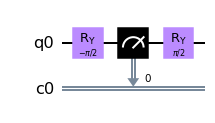

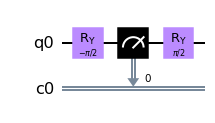

In [3]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,0)
circ.draw('mpl')

Recall that the measurement process takes the state of qubit and writes it to the classical register, which is just a blank set of slots (also initialized to zero). When we begin taking multiple measurements, we'll need to write to different slots on the classical register to record all the measurements. 

But for now, this should do it. Let's see what happens. For simplicity, we'll run the simulator and an actual device and show both sets of results on the same histogram:

In [4]:
IBMQ.load_account() 

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = IBMQ.get_provider(hub='ibm-q-education', group='high-point-uni-1', project='phy-3310')

In [6]:
job = execute(circ,backend=BasicAer.get_backend('qasm_simulator'),shots=1024)
counts = job.result().get_counts()

qcomp = provider.get_backend('ibmq_jakarta')
job = execute(circ,backend=qcomp)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts_q = job.result().get_counts()

Job Status: job has successfully run


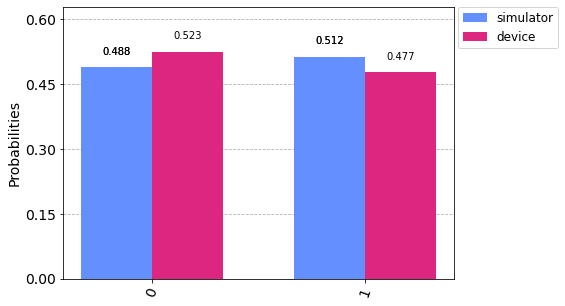

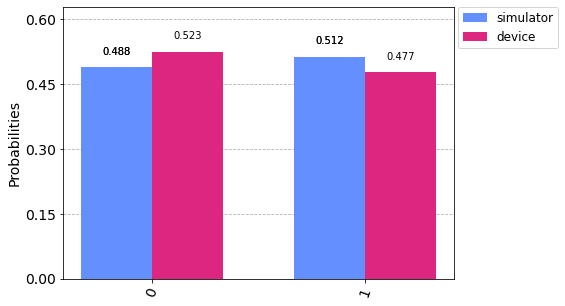

In [8]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([counts,counts_q],legend=['simulator','device'])

Recall that we need to interpet '0' or '1' as '+' or '-' <i>in this basis for which the measurment is performed</i>. We conclude that of all the spins initialized in $\left|+\right\rangle$, about half were measured to be $\left|+\right\rangle_{x}$ while the other half were measured to be in $\left|-\right\rangle$. So far nothing too magical.
    
Surely, measuring $\hat{S}^{z}$ one more time would return $+$ for all measurements since the state began in that eigenstate. We can explore this by adding another measurement. Since this will require a larger classical register to store two measurements, we'll just redo the circuit:

In [9]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

┌──────────┐┌─┐┌─────────┐┌─┐
q34_0: ┤ RY(-π/2) ├┤M├┤ RY(π/2) ├┤M├
       └──────────┘└╥┘└─────────┘└╥┘
 c1: 2/═════════════╩═════════════╩═
                    1             0

One potentially confusing item (at least for me): It appears the the classical register state appears written right-to-left. I tend to think left-to-right in most cases, so I have written the first measurement to ```cr[1]``` and the second to ```cr[0]```. It doesn't matter which measurement gets stored where, but (as of the time of writing this) this appears be necessary to get an output that can be read from left to right (but more on this below!). For completion, here is the Stern-Gerlach setup being used:

<img src="images/sg2.png" alt="sg2" width="600"/>

As before, the initialization on the backend takes care of the first $\hat{S}^{z}$ measurement. Note that the Stern-Gerlach experiment only feeds the $\left|+\right\rangle_{x}$ into the final analyzer. There is nothing in our quantum circuit that makes this restriction, but we will be able to account for this once we get the counts--the joys of post-processing!

So let's run this thing and see what happens:

In [13]:
job = execute(circ,backend=BasicAer.get_backend('qasm_simulator'),shots=1024)
counts = job.result().get_counts()

qcomp = provider.get_backend('ibmq_casablanca')
job = execute(circ,backend=qcomp)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts_q = job.result().get_counts()

Job Status: job has successfully run


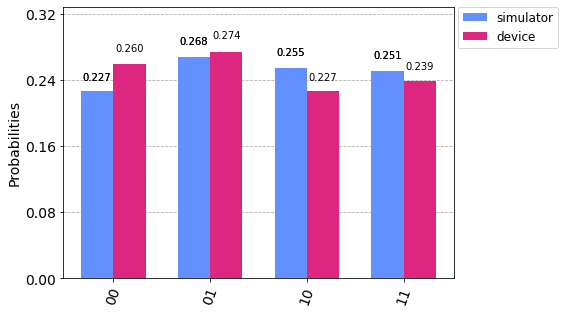

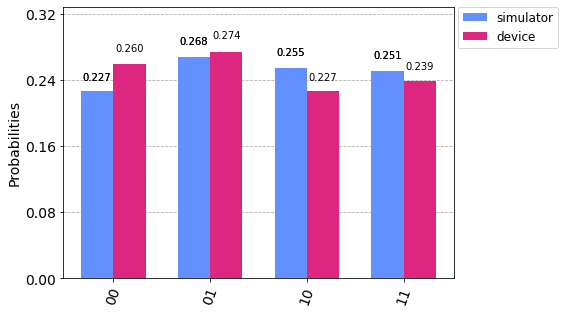

In [14]:
plot_histogram([counts,counts_q],legend=['simulator','device'])

Crudely, it looks like about a quarter of the initial $\left|+\right\rangle$ spins go into each state. There's a bit to unpack here, so let's do it carefully.

The classical register stores the outcomes ('0' or '1' in qubit language corresponding to '+' or '-' in spin language) of a single measurement. Our "counts" tell us all of the classical register states and how many times each was observed. 

Let's start with '00'. In the spin language, this is '++'. But the register doesn't record the measurement direction, so we have to reintroduce that information when interpreting what it means. Recalling that we begin with a state $\left|+\right\rangle$, we measured $\hat{S}^{x}$ and then measured $\hat{S}^{z}$. Thus, the state labeled by '00' means the measurment of $\hat{S}^{x}$ returned +$\frac{\hbar}{2}$, projecting the system into the eigenstate $\left|+\right\rangle_{x}$, and the subsequent measurement of $\hat{S}^{z}$ resulted in $+\frac{\hbar}{2}$. Since the initialization <i>gave</i> us a state with $S^{z} = + \frac{\hbar}{2}$, this all seems quite reasonable.

But the <i>funny</i> business concerns the existence of states '01' and '11'. The second register element being '1' indicates that the $\hat{S}^{z}$ measurement returned $-\frac{\hbar}{2}$. This is bizarre because it's like observing that an apple is red, tasting it to find that it is sweet, and then looking to see that it is green. Well that's a sloppy analogy, but no analogy is perfect.


Let's dive in to examine this more deeply. In the following exercises, you're going to make some simple modifications to the circuits presented above.

<b>Exercise: </b> Perhaps a quantum measurement simply kicks the state randomly. Reconfigure the circuit to simply measure $\hat{S}^{z}$ twice. Interpret your result in words.

In [48]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_sz(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

job = execute(circ,backend=BasicAer.get_backend('qasm_simulator'),shots=1024)
counts = job.result().get_counts()

qcomp = provider.get_backend('ibmq_casablanca')
job = execute(circ,backend=qcomp)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts_q = job.result().get_counts()

Job Status: job has successfully run


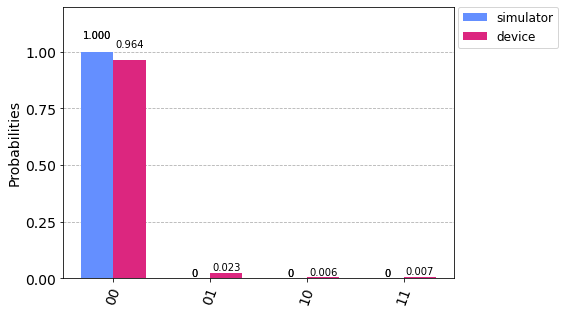

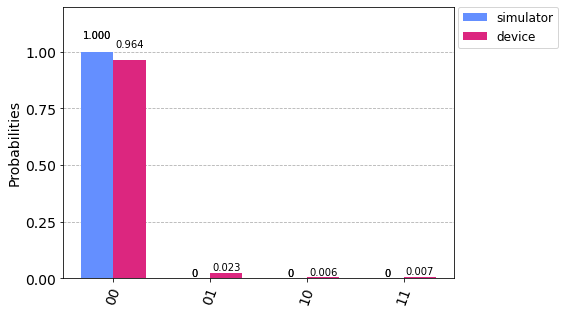

In [49]:
plot_histogram([counts,counts_q],legend=['simulator','device'])

Here we see that repeated measurements of $\hat{S}^{z}$ consistently return the same value. That is, '00' refers to repeated measurements of "+" whereas a reading of '01' would follow from a measurement of $S^{z}\rightarrow +\frac{\hbar}{2}$ followed by an immediate measurement of $S^{z}$ which yielded $-\frac{\hbar}{2}$. Given that '00' is essentially the only result (aside from noise, error), one can conclude that repeated measurements of $\hat{S}^{z}$ will give the same value. 

It's only when a non-commuting observable is measured between successive measurements that different results are obtained.

<b>Exercise: </b> Instead of $\hat{S}^{z}$, try measuring $\hat{S}^{x}$ twice. Are the results the same as the previous case? Why or why not?

In [53]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,1)
circ = measure_sx(circ,0,0)
circ.draw()

job = execute(circ,backend=BasicAer.get_backend('qasm_simulator'),shots=1024)
counts = job.result().get_counts()

qcomp = provider.get_backend('ibmq_casablanca')
job = execute(circ,backend=qcomp)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts_q = job.result().get_counts()

Job Status: job has successfully run


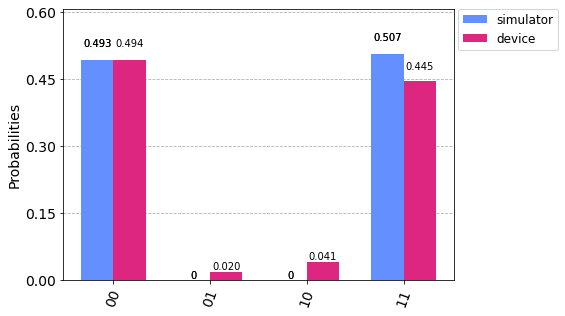

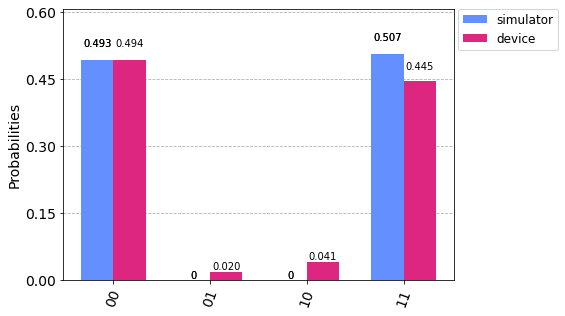

In [54]:
plot_histogram([counts,counts_q],legend=['simulator','device'])

From the histogram, we see that the measurements are roughly evenly divided between '00' and '11'. Recall that the circuit measures $\hat{S}^{x}$ twice given an initial state of $\left|+\right\rangle$. This splitting means that the initial state gives $S^{x} = \pm\frac{\hbar}{2}$ with roughly equal frequency upon the first measurement. The only states with any significant probability (at the end of the circuit) are '00' and '11', so we can say definitively that any of the initial spins which registered $S^{x} = + \frac{\hbar}{2}$ upon the first measurement also give the same value in the second measurement (and similar for $S^{x} = -\frac{\hbar}{2}$).

Given the results of the previous exercise, we can conclude that repeated measurements on an eigenstate (of that operator) will yield a consistent value for that observable. However, measuring <i>other</i> observables <i>can</i> destroy the notion of a well-defined value for the first observable. 

<b>Technical note: </b> We will see again and again that two <i>commuting</i> operators have simultaneous eigenvalues, so we can assign well-defined values to both quantities. It's when the operators don't commute that we run into this quantum weirdness. 

<b>Exercise</b>: Open the SPINS program and run the following simulation:

<img src="images/spins1.png" alt="spins1" width="600"/>

Now construct a quantum circuit to simulate this case. Note that the Stern-Gerlach setup only <i>analyzes</i> the $\hat{S}^{x}$ states without recording a measurement. You can mimic this by modifying the function ```measure_sx()``` to ```analyze_sx()``` as follows:

```
def analyze_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    #circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit
```

This is sloppy programming, but it emphasizes that all you're changing is to delete the actual measurement. The rotation (and anti-rotation) still takes place and represents the "analyzing" done in the SPINS software. 

Interpret your results.

<b>Solution:</b>

Here's the SPINS result for $N = 10^{4}$:

<img src="images/spins2.png" alt="spins2" width="600"/>

Note that all of the selected spins from the first analuzer make it to $+\frac{\hbar}{2}$ in the final analyzer. To simulate this:

In [44]:
def analyze_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    #circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit

In [45]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = analyze_sx(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

┌──────────┐┌─────────┐┌─┐
q159_0: ┤ RY(-π/2) ├┤ RY(π/2) ├┤M├
        └──────────┘└─────────┘└╥┘
  c8: 2/════════════════════════╩═
                                0

In [46]:
job = execute(circ,backend=BasicAer.get_backend('qasm_simulator'),shots=1024)
counts = job.result().get_counts()

qcomp = provider.get_backend('ibmq_casablanca')
job = execute(circ,backend=qcomp)

from qiskit.tools.monitor import job_monitor
job_monitor(job)

counts_q = job.result().get_counts()

Job Status: job has successfully run


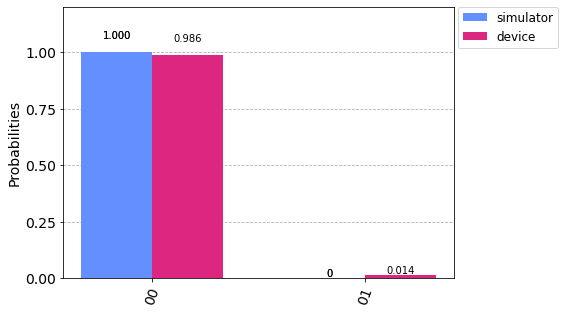

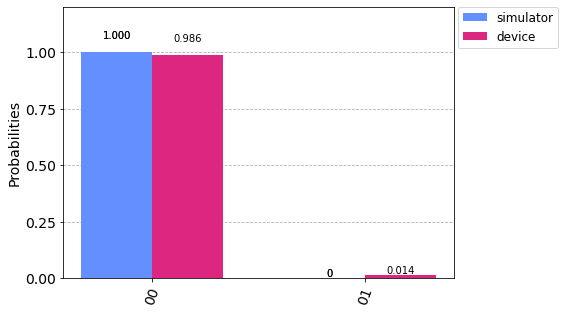

In [47]:
plot_histogram([counts,counts_q],legend=['simulator','device'])

Despite the rotations involved in "analyzing" the spin component, essentially all states still $\left|+\right\rangle$. It appears that the measurement of $\hat{S}^{x}$ is crucial in destroying the coherence of this initial state.

<b> (*) Challenge Exercise: </b> If you find yourself yearning for more, here's a fun task. We'll cover this in detail next week, but it might be a fun thing to play with if you can't fall asleep (or, like me, can't stay asleep) and want something fun to occupy your restless mind.

It's actually possible to "thread" parameters in such a way that you can send a whole series of circuits to be evaluated at once (well, one after the other). We'll use this shortly, but here's an opportunity to jump ahead and look at what happens as one slowly varies the "middle" spin analyzer:

<img src="images/sg3.png" alt="sg3" width="600"/>

Suppose $\hat{n} = \hat{n}(\theta,0)$ with $0\leq \theta \leq 2\pi$. You can sample $\theta$ over this range to see how the final counts vary as a function of $\theta$. The main goal of this question is to make a plot of $\left\langle \hat{S}^{z}\right\rangle$ as measured at the final circuit as a function of $\theta$. Some potentially useful hints follow:

- You can measure spin about some arbitrary axis with the following function

```
def measure_stheta(circuit,theta,phi,qreg,creg):
    circuit.rz(-phi,qreg)
    circuit.ry(-theta,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(theta,qreg)
    circuit.rz(phi,qreg)
    return circuit
```

- To loop your circuit over several values of $0<\theta<2\pi$, you can define the following:

```
from qiskit.circuit import Parameter
Ntheta = 75
theta = Parameter('θ')
theta_range = np.linspace(0, 2*np.pi, Ntheta)
```

   Note that if you want to use Greek characters in Code cells, you can type ```\theta``` and then hit the ```TAB``` key. But if you want to "cheat," you can also just copy and paste the code blocks in this cell. I didn't tell you that, but maybe you already figured it out.

   <b>Important warning: </b> Different backends have different allowed numbers of circuits that they can take in a single job. It seems 75 is safe for most as of the time of writing this, but you should always check the backends by logging in to the IBM Quantum site. But the worst that will happen is that you get an error that pretty clearly tells you ```Ntheta``` was too large. 
   
   To actually execute a circuit over multiple values of $\theta$, you can write something like
   
```
job = execute(circuit,
          backend=BasicAer.get_backend('qasm_simulator'),
          parameter_binds=[{theta: theta_val} for theta_val in theta_range])
                 
counts = job.result().get_counts()
```

In the sample command above, the QASM simulator is used. It's assumed that you have already constructed the ($\theta$-dependent) circuit at this point. Remember to use the ```job_monitor(job)``` command to get some real-time update on how your job is fairing in the queue! To run it on actual quantum hardware, you just have to call a real backend instead of the simulator (as we've done several times). The rest of the command should remain as is.

- Lastly, it's a nontrivial task to make sense of the results once you run such a job. You should take a moment to just print out what ```counts``` looks like. It is actually a nested list, where each inner layer is a dictionary giving the counts for each of the possible classical register states. Your actual circuit makes two measurements (spin along $\hat{n}$ followed by spin along $z$), so if you print out ```counts```, you should see something like

```
[{'00': 1024},
 {'00': 1023, '11': 1},
 {'00': 1009, '01': 7, '11': 8},
 {'00': 985, '11': 19, '01': 19, '10': 1},
 {'00': 963, '01': 29, '11': 31, '10': 1},
 {'00': 940, '11': 45, '01': 36, '10': 3},
 {'00': 911, '01': 62, '11': 45, '10': 6},
 {'01': 64, '00': 872, '10': 10, '11': 78},
 ...]
 ```
 
 That is, you get a collection of lists ```{...}``` where each enclosed list contains counts for the possible two-character readings in the classical register. The immediate question is: how does one extract $\left\langle\hat{S}^{z}\right\rangle$ from all of this?
 
With such a simple set of outcomes, a quick and dirty way to make sense of this is to just manually extract the counts of each outcome for each value of $\theta$. Letting ```n00``` be the number of counts of the outcome '00', we can extract this via:

```
n00 = list(map(lambda c: c.get('00', 0), counts))
```

A similar extraction can be performed for the other states by just changing <i>both</i> instances of '00' to '01', '10', '11'. Now let's step back and think about what we're trying to do. The final digit refers to the measurement of $\hat{S}^{z}$, while the first refers to the measurement of $\hat{S}^{x}$. Since we are <i>only</i> taking the "up" states from that $\hat{S}^{x}$ measurement, the only states relevant to our measurement are '00' and '01', since '10' and '11' refer to states discarded after the $\hat{S}^{x}$ measurement. To get an experimental value for $\left\langle \hat{S}^{z}\right\rangle$, we therefore just need to take an average over the relevant states.

Noting that '00' corresponds to $S^{z}\rightarrow +\frac{\hbar}{2}$ and '01' corresponds to $S^{z}\rightarrow -\frac{\hbar}{2}$, we let $\hbar = 1$ for simplicity and compute the average as

$$\left\langle \hat{S}^{z}\right\rangle = \frac{1}{2}\frac{\texttt{n00}-\texttt{n01}}{\texttt{n00} + \texttt{n01}}$$

This can be performed computationally within a simple loop:

```
Sz = zeros(Ntheta)

for i in range(0,Ntheta):
    Sz[i] = 0.5*(n00[i]-n01[i])/(n00[i]+n01[i])
```

The ```if``` statement is just a formality. If you follow all of these steps, you should be able to generate an informative plot via

```
plt.plot(theta_range,Sz,'b.')
plt.show()
```

One last question: a general state is given by $\left|\psi\right\rangle = \cos\frac{\theta}{2}\left|+\right\rangle + e^{i\phi}\sin\frac{\theta}{2}\left|-\right\rangle$. We have essentially rotated the state through the range $0<\theta<2\pi$. What happens to the wavefunction upon $\theta\rightarrow\theta + 2\pi$? Does the state actually return "to itself?"

<b>Spoiler: </b> It <i>doesn't!</i> But are there any observable consequences?

<b>Spoiler of the spoiler: </b> It's subtle. We have much to learn!

<b>Solution: </b>

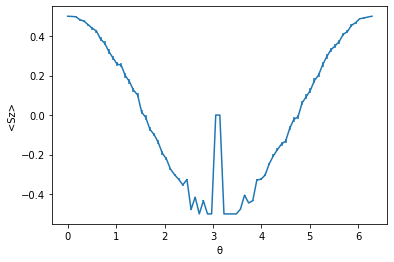

In [14]:
def measure_stheta(circuit,theta,phi,qreg,creg):
    circuit.rz(-phi,qreg)
    circuit.ry(-theta,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(theta,qreg)
    circuit.rz(phi,qreg)
    return circuit

from qiskit.circuit import Parameter
Ntheta = 75
theta = Parameter('θ')
theta_range = np.linspace(0, 2*np.pi, Ntheta)

qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_stheta(circ,theta,0,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

Nshot = 1024

job = execute(circ,
          backend=BasicAer.get_backend('qasm_simulator'),shots=Nshot,
          parameter_binds=[{theta: theta_val} for theta_val in theta_range])
                 
counts = job.result().get_counts()

n00 = list(map(lambda c: c.get('00', 0), counts))
n01 = list(map(lambda c: c.get('01', 0), counts))
n10 = list(map(lambda c: c.get('10', 0), counts))
n11 = list(map(lambda c: c.get('11', 0), counts))

Sz = np.zeros(Ntheta)
dSz = np.zeros(Ntheta)

for i in range(0,Ntheta):
    if ((n00[i]+n01[i])==0):
        Sz[i] = 0
    else:
        Sz[i] = 0.5*(n00[i]-n01[i])/(n00[i]+n01[i])
        
    varSz = (1.0/Nshot)*(n00[i]*((0.5-Sz[i])**2) + n01[i]*((-0.5-Sz[i])**2))
    dSz[i] = np.sqrt(varSz/Nshot)

plt.errorbar(theta_range,Sz,dSz)
#plt.plot(theta_range,Sz,'b.')
plt.xlabel('θ')
plt.ylabel('<Sz>')
plt.show()

Note the odd point off. When noise is involved, that's unlikely to occur. 

In the course, we'll learn how to <i>calculate</i> this expectation value. The answer ends up being

$$\left\langle \hat{S}^{z}(\theta)\right\rangle = \frac{\hbar}{2}\cos\theta$$

After we run it on real hardware, we find:

In [39]:
qcomp = provider.get_backend('ibmq_casablanca')
job = execute(circ,
          backend=qcomp,shots=8192,
          parameter_binds=[{theta: theta_val} for theta_val in theta_range])

job_monitor(job)
counts = job.result().get_counts()

n00 = list(map(lambda c: c.get('00', 0), counts))
n01 = list(map(lambda c: c.get('01', 0), counts))
n10 = list(map(lambda c: c.get('10', 0), counts))
n11 = list(map(lambda c: c.get('11', 0), counts))

Sz = np.zeros(Ntheta)

for i in range(0,Ntheta):
    if ((n00[i]+n01[i])==0):
        Sz[i] = 0
    else:
        Sz[i] = 0.5*(n00[i]-n01[i])/(n00[i]+n01[i])

Job Status: job has successfully run


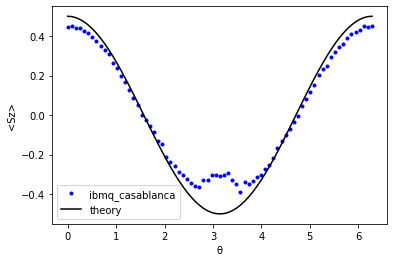

In [43]:
Sztheory = 0.5*np.cos(theta_range)

plt.plot(theta_range,Sz,'b.')
plt.plot(theta_range,Sztheory,'k-')
plt.xlabel('θ')
plt.ylabel('<Sz>')
plt.legend(['ibmq_casablanca','theory'])
plt.show()

Note two things here: (1) The region around $\theta \approx \pi$ shows particularly large error between theory and experiment and (2) as $\theta\rightarrow0,2\pi$, the error also increases. Noise and gate/measurement errors tend to <i>reduce</i> coherence, so correlations tend to be smaller in magnitude than theory predicts.